# Locust Prediction Modelling

Notes:

- `observation_date` is already encoded as `year`, `month`, `day`, separately
- The `dekad` variables are used for pseudo-absence generation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_train = pd.read_csv("../data/train_val_random.csv", index_col=0)
data_test = pd.read_csv("../data/test_random.csv", index_col=0)
data_train.head()

,x,y,presence,year,month,day,clay_0.5cm_mean,clay_5.15cm_mean,sand_0.5cm_mean,sand_5.15cm_mean,...,SoilMoi0_10cm_inst_95,SoilMoi10_40cm_inst_95,SoilTMP0_10cm_inst_95,SoilTMP10_40cm_inst_95,Tveg_tavg_95,Wind_f_inst_95,Rainf_f_tavg_95,Tair_f_inst_95,Qair_f_inst_95,Psurf_f_inst_95
0,-13.899444,19.156944,1,2000,11,27,0.199897,0.207781,0.587636,0.580589,...,21.949375,72.536621,309.327972,308.586700,0.0,2.366373,0.0,308.427795,0.006704,98936.21875
1,-13.910278,19.144444,1,2000,11,27,0.200571,0.208502,0.587100,0.579985,...,21.949375,72.536621,309.327972,308.586700,0.0,2.366373,0.0,308.427795,0.006704,98936.21875
2,-13.923056,19.146667,1,2000,11,27,0.200300,0.208099,0.586820,0.579769,...,21.949375,72.536621,309.327972,308.586700,0.0,2.366373,0.0,308.427795,0.006704,98936.21875
3,-12.945833,19.146389,1,2000,11,28,0.201479,0.211707,0.580777,0.574105,...,21.541126,71.466125,308.702087,309.064667,0.0,3.542690,0.0,307.616486,0.010070,99162.62500
4,-12.949722,19.133056,1,2000,11,28,0.202332,0.212883,0.580030,0.573147,...,21.541126,71.466125,308.702087,309.064667,0.0,3.542690,0.0,307.616486,0.010070,99162.62500


In [3]:
# assert len(data_train.drop(columns="presence").columns), len(data_test.columns)
missing_in_train = [n for n in data_test.columns if n not in data_train.columns]
missing_in_test = [n for n in data_train.columns if n not in data_test.columns]

print(f"Train missing {len(missing_in_train)} columns")
print(f"Test missing {len(missing_in_test)} columns")

data_test = data_test.drop(columns=missing_in_train)
data_train = data_train.drop(columns=missing_in_test)

Train missing 0 columns
Test missing 0 columns


In [4]:
cats = data_train.select_dtypes(np.integer).columns.tolist()
objects = data_train.select_dtypes(np.object).columns.tolist()
floats = data_train.select_dtypes(np.float).columns.tolist()
assert len(cats) + len(objects) + len(floats) == len(data_train.columns)

print("Objects:", objects)
print("Categoricals:", cats)
print("Floats:", floats[:10])

Objects: ['observation_date']
Categoricals: ['presence', 'year', 'month', 'day']
Floats: ['x', 'y', 'clay_0.5cm_mean', 'clay_5.15cm_mean', 'sand_0.5cm_mean', 'sand_5.15cm_mean', 'silt_0.5cm_mean', 'silt_5.15cm_mean', 'AvgSurfT_inst_0', 'Albedo_inst_0']


In [5]:
data_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22102 entries, 0 to 22101
Columns: 1165 entries, x to Psurf_f_inst_95
dtypes: float64(1160), int64(4), object(1)
memory usage: 196.6+ MB


In [6]:
# Check for NAN values
nans = data_train.isnull().sum()
# [(k,v,d) for k,v,d in zip(nans.keys(), nans.values, data_train.dtypes) if v>0]

In [7]:
# Fill NAN values with median
# for col in data_train.columns:
#     n_train_nans = pd.isnull(data_train[col]).sum()
#     n_test_nans = pd.isnull(data_test[col]).sum()
#     if data_train[col].dtype == np.float:
#         m = data_train[col].median()
#         if n_train_nans:
#             data_train[col] = data_train[col].fillna(m)
#         if n_test_nans:
#             data_test[col] = data_test[col].fillna(m)

data_train.dropna(inplace=True)
data_test.dropna(inplace=True)

assert not data_train.isnull().sum().sum()
assert not data_test.isnull().sum().sum()

In [8]:
non_temporal_columns = ['sand_0.5cm_mean', 'sand_5.15cm_mean']
temporal_variables = [
    'AvgSurfT_inst', 
    # 'Albedo_inst', 
    'SoilMoi0_10cm_inst', 
    'SoilMoi10_40cm_inst', 
    'SoilTMP0_10cm_inst', 
    'SoilTMP10_40cm_inst', 
    'Tveg_tavg', 
    'Wind_f_inst', 
    'Rainf_f_tavg', 
    'Tair_f_inst',
    'Qair_f_inst', 
    'Psurf_f_inst'
]

def grouplen(sequence, chunk_size):
    return list(zip(*[iter(sequence)] * chunk_size))

def preprocess_data(data, days=6, drop_true_absence=True):
    """Bucketize temporal columns"""
    if drop_true_absence:
        data = data[data['presence'] != 2]
    dfs = []
    for temp_variable in temporal_variables:
        chunks = grouplen([col for col in data.columns if temp_variable in col], days)
        agg_list = list(map(lambda x: data[list(x)].min(axis=1), chunks))
        df = pd.concat(agg_list, axis=1)
        df.columns = [f"{temp_variable}_bucket_{i}" for i in range(1, df.shape[1]+1)]
        dfs.append(df)
    dfs.append(data[non_temporal_columns])
    return pd.concat(dfs, axis=1), data['presence']

In [9]:
# drops = ["observation_date", "date", "Unnamed: 0.1", "presence"]

# def process_targets(data):
#     target = data.presence.copy()
#     data = data.drop(columns=drops)
#     counts = list(zip(*np.unique(target, return_counts=True)))
#     print("Counts:", counts)
    
#     # merge pseudo-absence and true absence
#     target.loc[target == 2] = 0
#     return data, target

In [10]:
data_train, train_target = preprocess_data(data_train)
data_test, test_target = preprocess_data(data_test)

print(f"Train features: {data_train.shape}, Train labels: {train_target.shape}")
print(f"Test features: {data_test.shape}, Test labels: {test_target.shape}")

Train features: (21939, 178), Train labels: (21939,)
Test features: (3253, 178), Test labels: (3253,)


## Modelling

In [11]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [12]:
def evaluate(trues, preds):
    labels = ['absence', 'presence']
    results = {}
    results['accuracy'] = metrics.accuracy_score(trues, preds)
    results['confusion_matrix'] = metrics.confusion_matrix(trues, preds)
    results['kappa'] = metrics.cohen_kappa_score(trues, preds)
    results['f1'] = metrics.f1_score(trues, preds)
    
    print(metrics.classification_report(trues, preds, target_names=labels))
    return results

In [13]:
# Probably should split data sooner
seed = 111
train_x, val_x, train_y, val_y = train_test_split(
    data_train, train_target, test_size=0.2, random_state=seed)

## Logistic Regression

In [14]:
# Scale the dataset
scaler = preprocessing.MinMaxScaler()
train_x_scaled = scaler.fit_transform(train_x)
val_x_scaled = scaler.transform(val_x)
test_x_scaled = scaler.transform(data_test)

In [15]:
model = LogisticRegression()
model.fit(train_x_scaled, train_y);

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
y_preds = model.predict(val_x_scaled)
logistic_val_results = evaluate(val_y, y_preds)

              precision    recall  f1-score   support

     absence       0.69      0.64      0.66      2203
    presence       0.66      0.70      0.68      2185

    accuracy                           0.67      4388
   macro avg       0.67      0.67      0.67      4388
weighted avg       0.67      0.67      0.67      4388



In [17]:
y_preds = model.predict(test_x_scaled)
logistic_test_results = evaluate(test_target, y_preds)

              precision    recall  f1-score   support

     absence       0.64      0.66      0.65      1622
    presence       0.65      0.62      0.64      1631

    accuracy                           0.64      3253
   macro avg       0.64      0.64      0.64      3253
weighted avg       0.64      0.64      0.64      3253



In [18]:
# Feature importance
weights = model.coef_[0].tolist()
features = list(zip(weights, data_train.columns))
list(sorted(features, key=lambda x: abs(x[0]), reverse=True))[:10]

[(-3.081228319849832, 'Tair_f_inst_bucket_1'),
 (-2.606354029877095, 'SoilMoi10_40cm_inst_bucket_15'),
 (-2.4109677379062577, 'Tveg_tavg_bucket_11'),
 (-2.4003722845895674, 'Tair_f_inst_bucket_15'),
 (-2.2968336448680247, 'SoilMoi10_40cm_inst_bucket_16'),
 (-2.2567275910271283, 'Tair_f_inst_bucket_13'),
 (-2.1484228174758027, 'Tair_f_inst_bucket_2'),
 (1.950515639157716, 'SoilMoi0_10cm_inst_bucket_2'),
 (1.8720371714819257, 'sand_0.5cm_mean'),
 (-1.8266625791668452, 'Tair_f_inst_bucket_3')]

### XGBoost

In [19]:
train_xgb = xgb.DMatrix(train_x, label=train_y)
val_xgb = xgb.DMatrix(val_x, label=val_y)
test_xgb = xgb.DMatrix(data_test)

In [20]:
params = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
model = xgb.train(params, train_xgb)
y_preds = model.predict(val_xgb).round(0)
xgb_val_results = evaluate(val_y, y_preds)

[11:55:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

     absence       0.76      0.71      0.74      2203
    presence       0.73      0.77      0.75      2185

    accuracy                           0.74      4388
   macro avg       0.75      0.74      0.74      4388
weighted avg       0.75      0.74      0.74      4388



In [21]:
y_preds = model.predict(test_xgb).round(0)
xgb_test_results = evaluate(test_target, y_preds)

              precision    recall  f1-score   support

     absence       0.64      0.63      0.63      1622
    presence       0.64      0.65      0.64      1631

    accuracy                           0.64      3253
   macro avg       0.64      0.64      0.64      3253
weighted avg       0.64      0.64      0.64      3253



#### Feature Importance

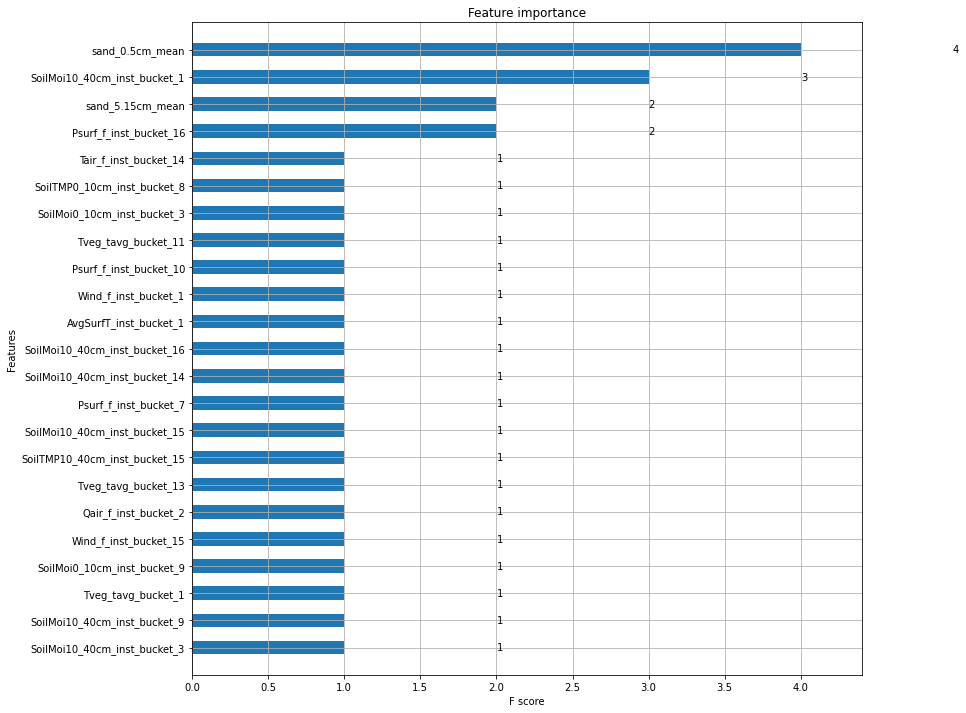

In [22]:
f,a = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, height=0.5, figure=f, ax=a);

### Random Forest

In [23]:
model = RandomForestClassifier()
model.fit(train_x, train_y)

In [ ]:
y_preds = model.predict(val_x)
rf_val_results = evaluate(val_y, y_preds)

              precision    recall  f1-score   support

     absence       0.88      0.88      0.88      2203
    presence       0.88      0.88      0.88      2185

    accuracy                           0.88      4388
   macro avg       0.88      0.88      0.88      4388
weighted avg       0.88      0.88      0.88      4388



In [ ]:
y_preds = model.predict(data_test)
rf_test_results = evaluate(test_target, y_preds)

              precision    recall  f1-score   support

     absence       0.55      0.85      0.67      1622
    presence       0.68      0.32      0.44      1631

    accuracy                           0.58      3253
   macro avg       0.62      0.59      0.55      3253
weighted avg       0.62      0.58      0.55      3253



## Results

### Validation

In [ ]:
val_results = pd.DataFrame({
    "Logistic": logistic_val_results, 
    "XGBoost": xgb_val_results, 
    "Random Forest": rf_val_results,
})
val_results

,Logistic,XGBoost,Random Forest
accuracy,0.592981,0.714904,0.881951
confusion_matrix,"[[1277, 926], [860, 1325]]","[[1522, 681], [570, 1615]]","[[1938, 265], [253, 1932]]"
kappa,0.186048,0.429917,0.763903
f1,0.597385,0.720821,0.881789


### Test

In [ ]:
test_results = pd.DataFrame({
    "Logistic": logistic_test_results, 
    "XGBoost": xgb_test_results, 
    "Random Forest": rf_test_results,
})
test_results

,Logistic,XGBoost,Random Forest
accuracy,0.535813,0.636028,0.584998
confusion_matrix,"[[655, 967], [543, 1088]]","[[868, 754], [430, 1201]]","[[1380, 242], [1108, 523]]"
kappa,0.070949,0.27165,0.171211
f1,0.590342,0.669827,0.436561


## Interpretation